# Wordart example notebook
Prototyping text source lookup via various API's and word cloud rendering with added features. Will eventually be a webapp most likely. 

## Imports

In [230]:
import requests
import json
import numpy as np
import math
import time
import pandas as pd
import nltk
from matplotlib import pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

from PIL import Image, ImageOps, ImageEnhance
from wordcloud import WordCloud, STOPWORDS

In [231]:
%run wordart.py
key = json.loads(open('private_data.json').read())['nytimes-api-key']

## Show/hide code

In [246]:
%%html

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<p>To toggle on/off display of the raw code for this notebook, <a href="javascript:code_toggle()">click here</a>.

## Fetch data

In [232]:
# sf bay
reader = NYTReader(key)
reader.get_search_term(search='headline:("San Francisco", "Oakland", "Silicon Valley")', 
                     begin_date='20010101',
                     article_limit=500)
print(len(reader.docs), min([x['pub_date'] for x in reader.docs]), max([x['pub_date'] for x in reader.docs]))

250 2001-01-14T00:00:00Z 2017-10-12T20:27:23+0000


In [233]:
# ca
reader_ca = NYTReader(key)
reader_ca.get_search_term(search='headline:("California")', 
                     article_limit=500)

print(len(reader_ca.docs), min([x['pub_date'] for x in reader_ca.docs]), max([x['pub_date'] for x in reader_ca.docs]))

510 1853-01-13T00:03:58Z 2016-06-27T11:13:09Z


In [234]:
# renewable energy
reader_green = NYTReader(key)
reader_green.get_search_term(search='headline:("Solar", "Wind", "Renewable")', 
                     begin_date='20010101',
                     article_limit=500)

print(len(reader_green.docs), min([x['pub_date'] for x in reader_green.docs]), max([x['pub_date'] for x in reader_green.docs]))

290 2001-03-10T00:00:00Z 2017-09-09T21:36:13+0000


In [235]:
# manhattan project
reader_bomb = NYTReader(key)
reader_bomb.get_search_term(search='headline:("Manhattan Project")', 
                     article_limit=500)

print(len(reader_bomb.docs), min([x['pub_date'] for x in reader_bomb.docs]), max([x['pub_date'] for x in reader_bomb.docs]))

20 1946-10-08T00:00:00Z 2015-01-01T07:11:58Z


## Testing different types of sources

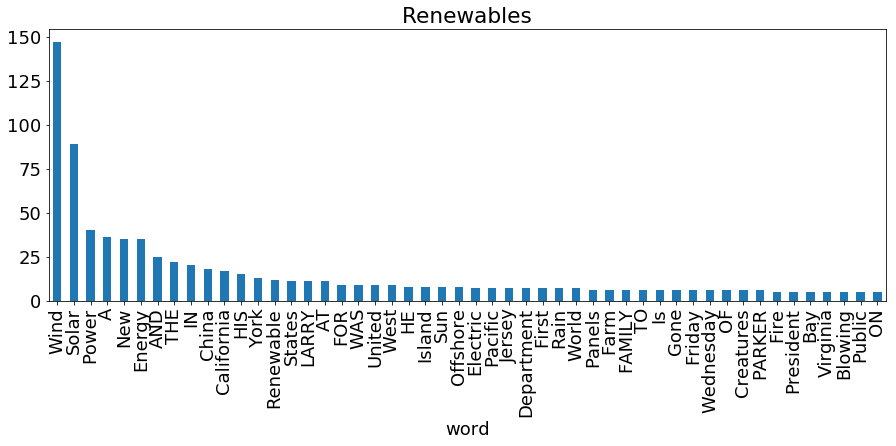

In [244]:
pos = reader.pos['include']
exclude = False
print_tuple = False

# sf bay
text = []
sources = [reader.headlines, reader.snippets,] #,reader.headlines]
for source in sources:
    text.extend(source)
#reader.plot_top_words(df=reader.df_from_text(text), n=50, title="SF Bay", 
                      #pos_list=pos, exclude=exclude, print_tuple=print_tuple)

# ca
text_ca = []
sources = [reader_ca.headlines, reader_ca.snippets,] #,reader.headlines]
for source in sources:
    text_ca.extend(source)
#reader_ca.plot_top_words(df=reader_ca.df_from_text(text_ca), n=50, title="CA", 
#                         pos_list=pos, exclude=exclude, print_tuple=print_tuple)

# renewable energy
text_green = []
sources = [reader_green.headlines, reader_green.snippets,] #,reader.headlines]
for source in sources:
    text_green.extend(source)
reader_green.plot_top_words(df=reader_green.df_from_text(text_green), n=50, title="Renewables", 
                         pos_list=pos, exclude=exclude, print_tuple=print_tuple)

# manhattan project
text_bomb = []
sources = [reader_bomb.headlines, reader_bomb.snippets,] #,reader.headlines]
for source in sources:
    text_bomb.extend(source)
#reader_bomb.plot_top_words(df=reader_bomb.df_from_text(text_bomb), n=50, title="Manhattan Project", 
#                         pos_list=pos, exclude=exclude, print_tuple=print_tuple)


## Build word list

In [237]:
# sf bay
text_words = reader.get_words(reader.df_from_text(text), pos_list=None, exclude=exclude)
text_string = ' '.join(text_words)
print(len(text_words), len(set(text_words)))

# ca
text_words_ca = reader_ca.get_words(reader_ca.df_from_text(text_ca), pos_list=None, exclude=exclude)
text_string_ca = ' '.join(text_words_ca)
print(len(text_words_ca), len(set(text_words_ca)))

# renewable
text_words_green = reader_green.get_words(reader_green.df_from_text(text_green), pos_list=None, exclude=exclude)
text_string_green = ' '.join(text_words_green)
print(len(text_words_green), len(set(text_words_green)))

# manhattan project
text_words_bomb = reader_bomb.get_words(reader_bomb.df_from_text(text_bomb), pos_list=None, exclude=exclude)
text_string_bomb = ' '.join(text_words_bomb)
print(len(text_words_bomb), len(set(text_words_bomb)))

7831 2999
19413 6873
9277 3385
789 437


## Read and modify some images

In [238]:
# sf bay
image = Image.open('source images/Location_Map_San_Francisco_Bay_Area_edited.gif')
image = image.convert(mode='RGB')

# ca
image_ca = Image.open('source images/kalifornien_schwarz.png')
image_ca = image_ca.resize([int(image_ca.size[0]/2), int(image_ca.size[1]/2)])
image_ca = image_ca.convert(mode='RGB')
image_ca = ImageOps.invert(image_ca)
image_ca = ImageEnhance.Contrast(image_ca).enhance(10)

# green energy
image_green = Image.open('source images/Renewable-Energy-Consultants.png')
image_green = image_green.convert(mode='L')
image_green = ImageEnhance.Contrast(image_green).enhance(10)

# bomb
image_bomb = Image.open('source images/ABomb.png')
image_bomb = image_bomb.rotate(270, expand=True).convert("RGBA")
background = Image.new(size=image_bomb.size, color='white', mode='RGBA')
image_bomb = Image.alpha_composite(background, image_bomb)
image_bomb= image_bomb.convert("RGB")
background = Image.new(size=[image_bomb.size[0]+200, image_bomb.size[1]+200], color='white', mode="RGB")
background.paste(image_bomb, (int((background.size[0]-image_bomb.size[0])/2),
                      int((background.size[1]-image_bomb.size[1])/2)))
image_bomb = background

## Define wordcloud fcn

In [239]:
def make_wordcloud(image, text_string, filename="final images/out.png", colormap='viridis', background=None, max_words=4000):
    
    #define mask as np array
    mask = np.array(image)
    
    # import and add stopwords
    stopwords = set(STOPWORDS)
    stopwords_to_add = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for word in stopwords_to_add: 
        stopwords.add(word)

    #initialize wordcloud
    wc = WordCloud(background_color="white", max_words=max_words, mask=mask,
                   stopwords=stopwords, colormap=colormap)#contour_width=3, contour_color='steelblue')

    # generate word cloud
    wc.generate(text_string)

    # store to file
    filename = filename.split('.')[0] + '_' + colormap + '.' + filename.split('.')[1]
    wc.to_file(filename)
    wc_image = Image.open(filename)
    
    # apply background 
    if background is not None:
        background = Image.new(size=image.size, color=background, mode='RGB')
        mask = ImageOps.invert(image.convert(mode='L'))
        wc_w_background = Image.composite(wc_image, background, mask)
        wc_w_background.save(filename.split('.')[0] + '_backgound' + '.' + filename.split('.')[1])
        
        return wc_w_background
    else:
        return wc_image

## Make some images

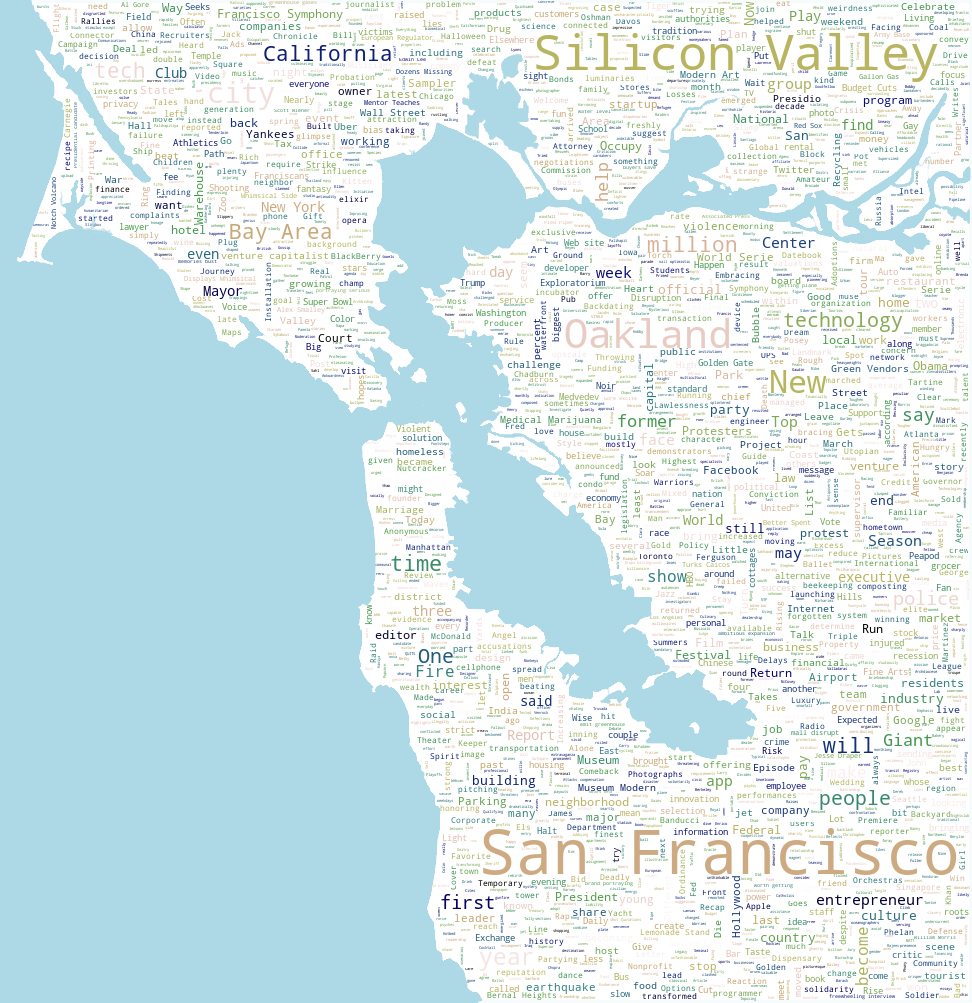

In [240]:
make_wordcloud(image=image, text_string=text_string, 
               filename="final images/sf_bay.png", 
               colormap='gist_earth', background='lightblue')

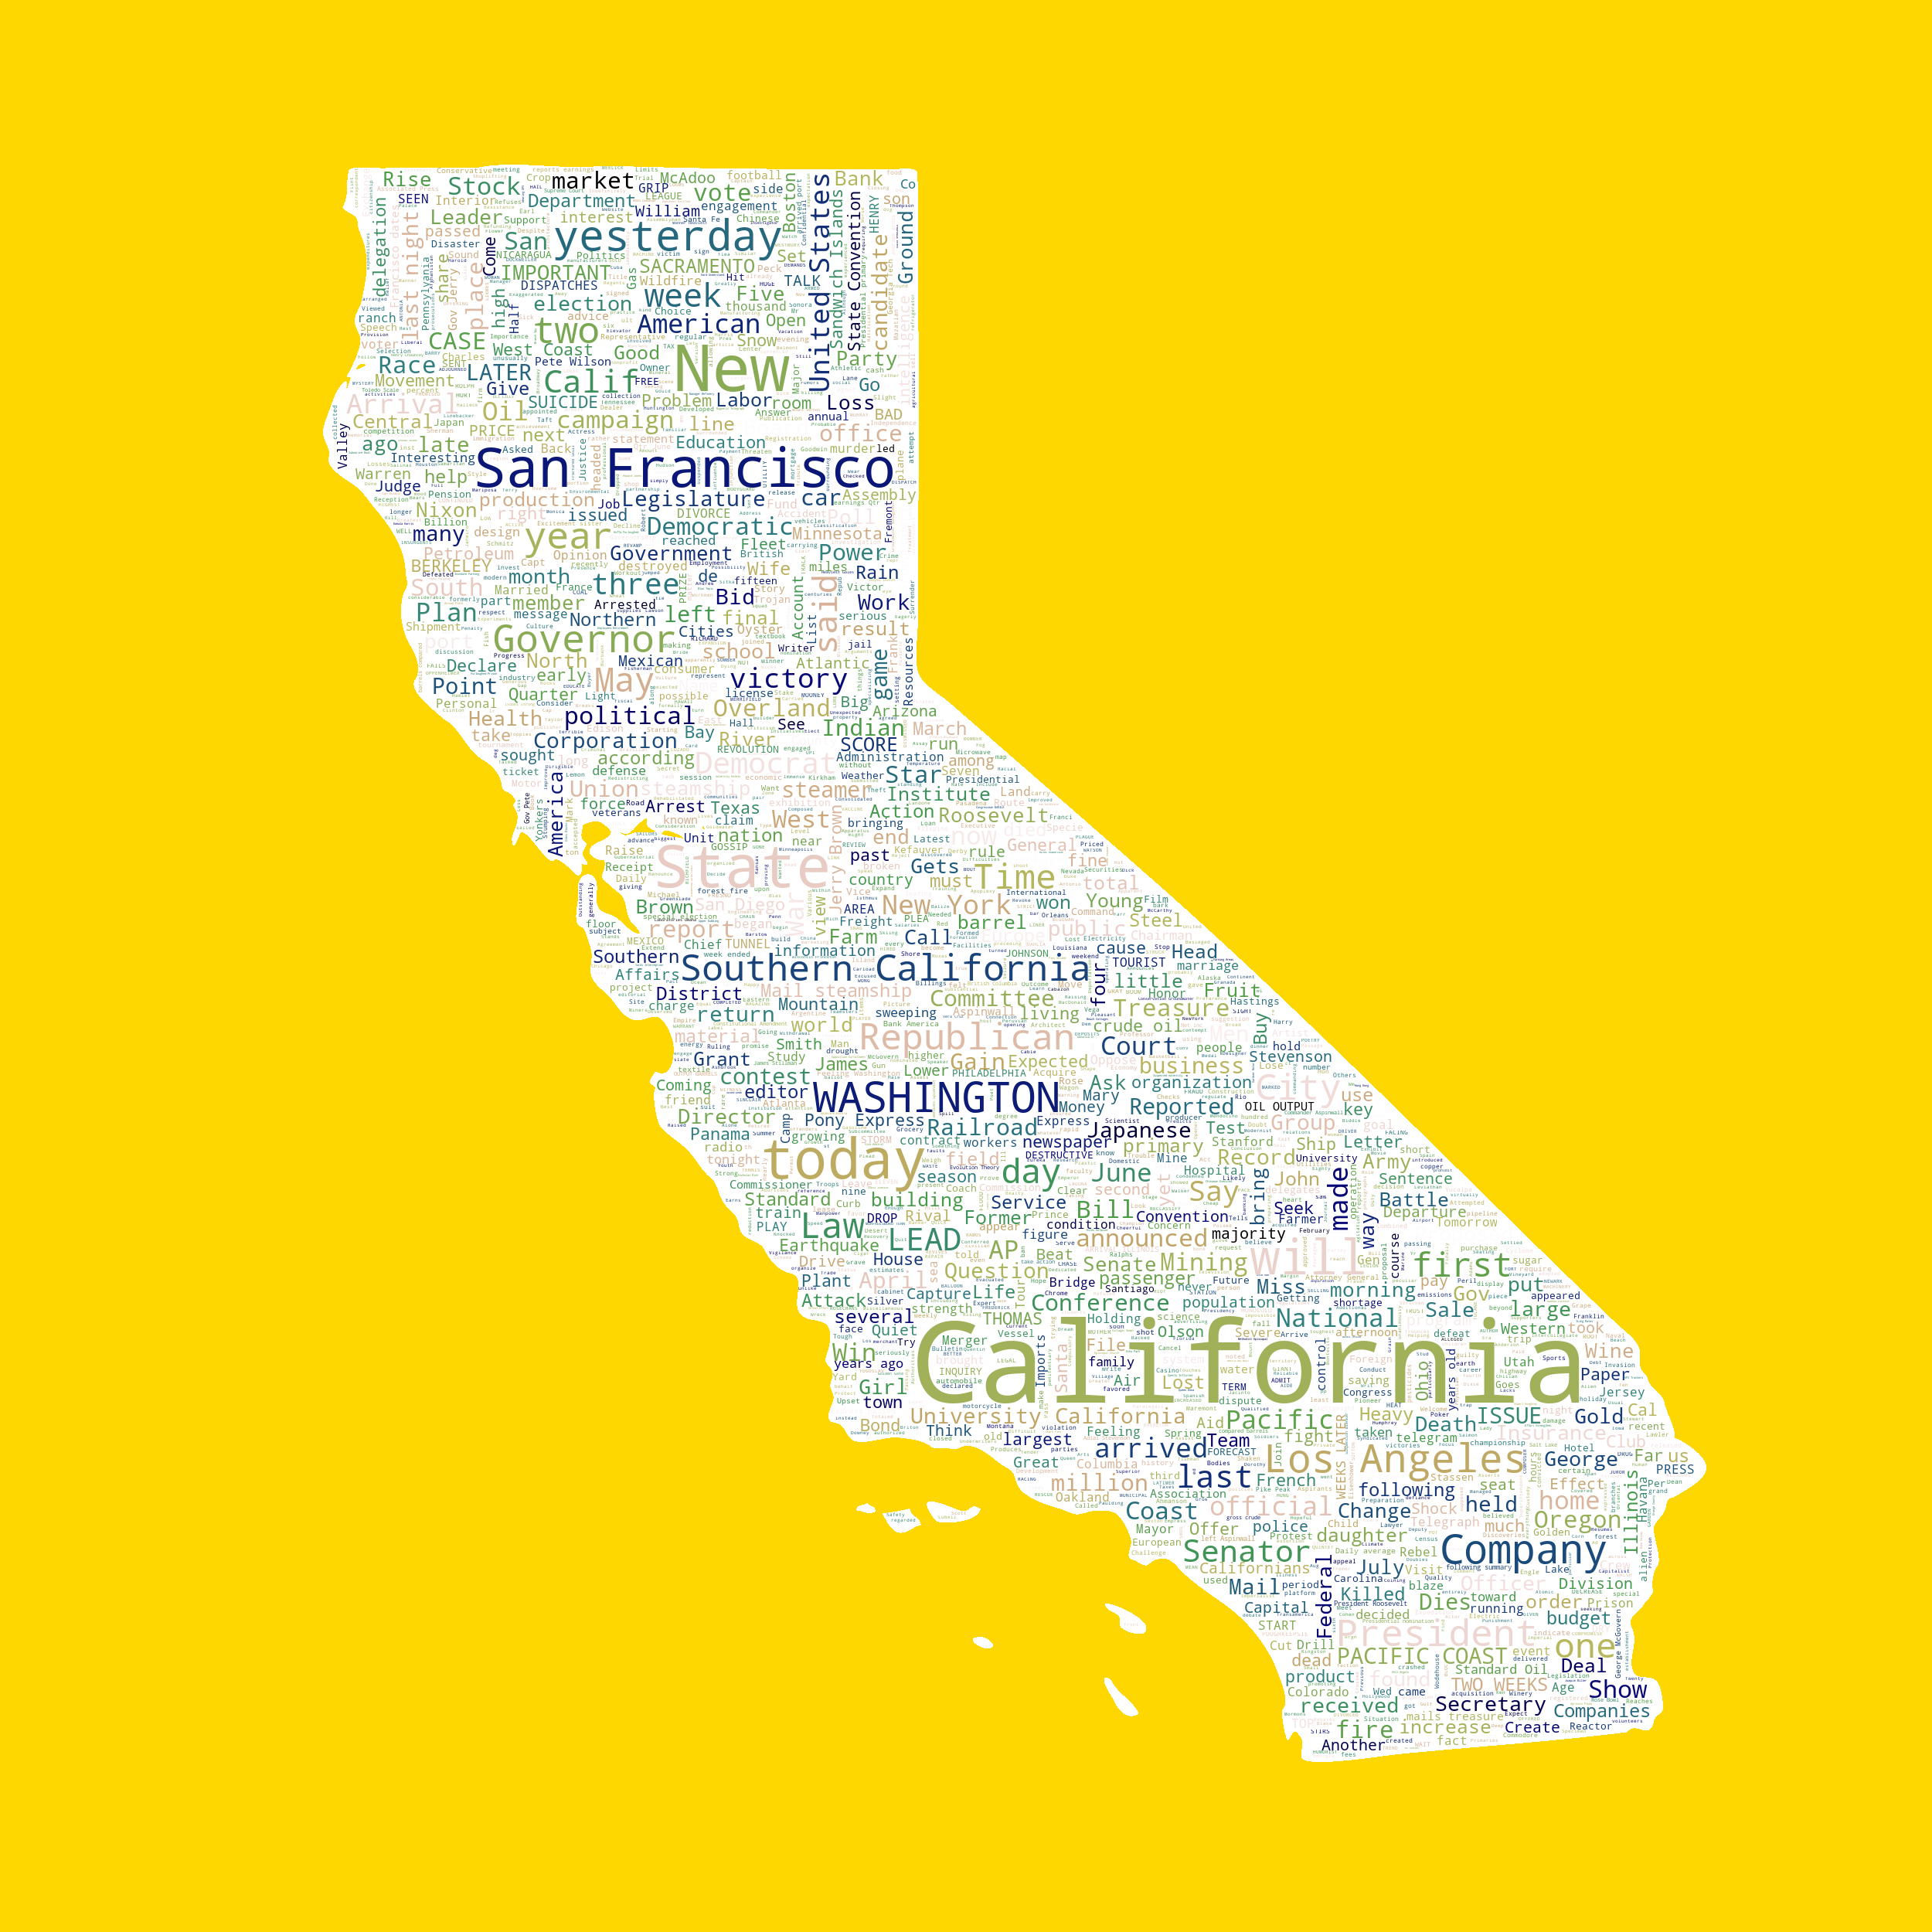

In [241]:
make_wordcloud(image=image_ca, text_string=text_string_ca, 
               filename="final images/ca.png", 
               colormap='gist_earth', background='gold')

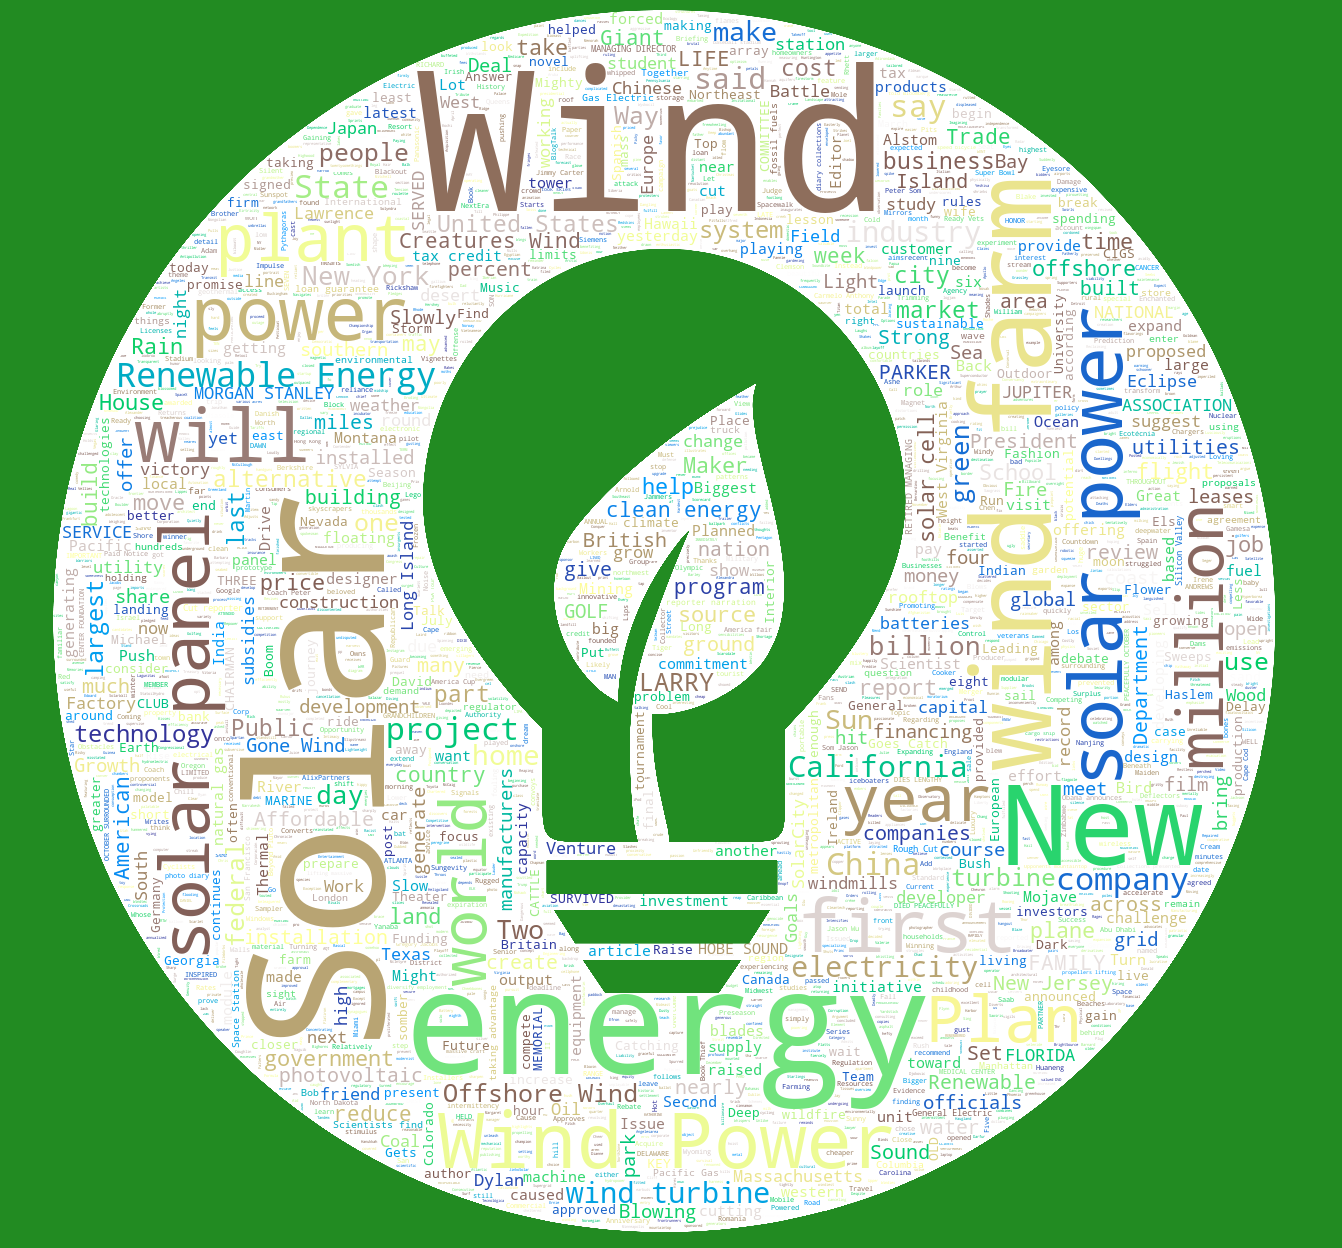

In [242]:
make_wordcloud(image=image_green, text_string=text_string_green, 
               filename="final images/green.png", 
               colormap='terrain', background='forestgreen')

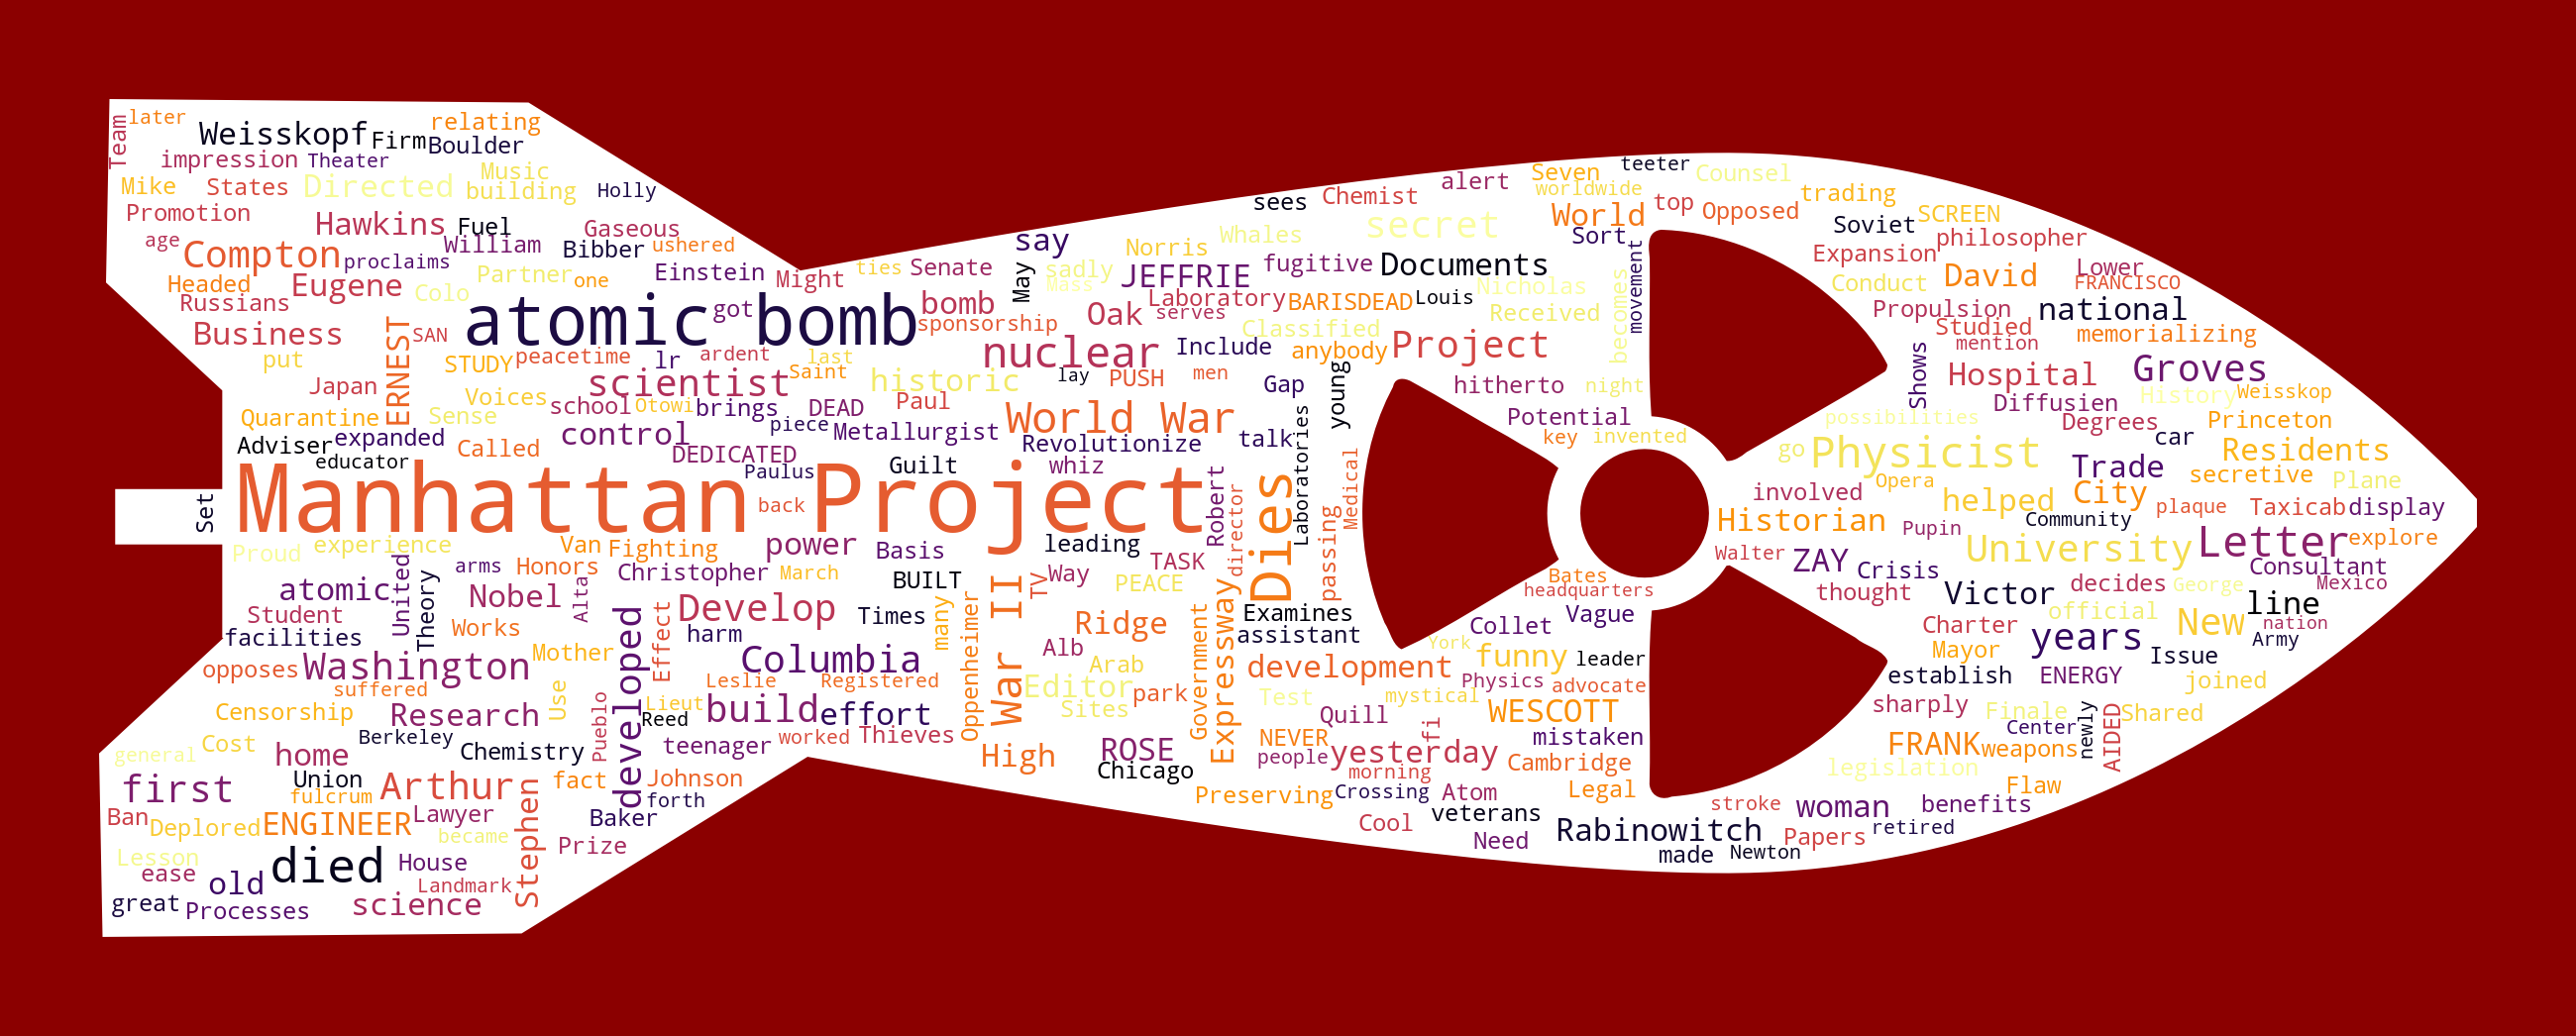

In [243]:
make_wordcloud(image=image_bomb, text_string=text_string_bomb, 
               filename="final images/bomb.png", 
               colormap='inferno', background='darkred')